### Load predictions

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting

reload(misc)
reload(plotting)

first_year = 1990

data_dir = '.'
data_file = os.path.join(data_dir, 'immigration_with_metadata_2017_03_13.csv')

data = misc.read_tone_data(data_file, first_year)

last_date = data['date'].max()

print "Loaded data for %d articles" % len(data.index)

Loaded data for 34770 articles


### Group data and plot tone and directness

Grouped data into 92 periods


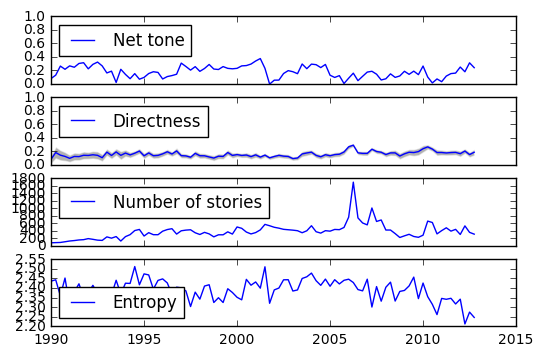

In [68]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'

reload(misc)
reload(plotting)

grouped = misc.group_tone_data(data, group_by)

print "Grouped data into %d periods" % len(grouped.index)

plotting.plot_variables(grouped)

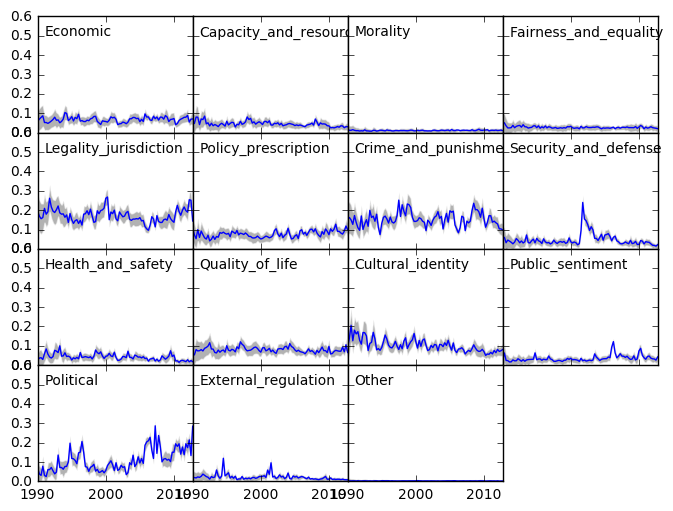

In [62]:
reload(plotting)

plotting.plot_frames(grouped)

### Load polling data

In [63]:
reload(misc)

filename = 'immigration_polls.csv'

polls = misc.load_polls(filename, first_year, last_date)
polls = polls[polls['Varname'] != 'IMMLEGAL']

print "Loaded %d polls" % len(polls.index)
print polls.shape

Loaded 69 polls
(69, 28)


(0, 1)

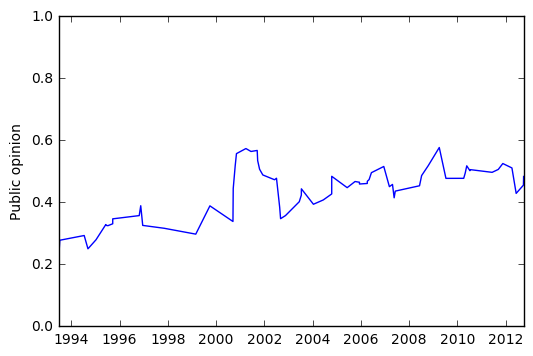

In [64]:
# calculate an exponentially-weighted running average for all polls and plot it

reload(misc)

running_average = misc.calculate_weighted_average(polls)
polls['running_average'] = running_average

plt.plot(polls['date'], polls['running_average']/100.0)
plt.ylabel('Public opinion')
plt.ylim(0, 1)

In [14]:
reload(misc)

combined = misc.combine_polls_with_preceeding_articles(polls, data, n_days=30)
#combined = misc.combine_polls_and_tone(polls, grouped)

print combined.describe()

             Pro    Neutral       Anti  directness     stories    entropy  \
count  69.000000  69.000000  69.000000   69.000000   69.000000  69.000000   
mean    0.504054   0.166237   0.329709    0.176559  170.130435   2.382082   
std     0.055077   0.026124   0.051407    0.055578  124.425966   0.061293   
min     0.393174   0.125105   0.221169    0.093515   56.000000   2.240780   
25%     0.470906   0.146313   0.286846    0.139470  112.000000   2.344869   
50%     0.498950   0.158510   0.330249    0.168735  128.000000   2.396649   
75%     0.538979   0.184587   0.361141    0.191047  182.000000   2.420777   
max     0.631303   0.250843   0.433534    0.375660  763.000000   2.488323   

            tone      Value          N  running_average    IMMRATE     CNNIMM  \
count  69.000000  69.000000  69.000000        68.000000  69.000000  69.000000   
mean    0.174344   0.464336   0.384835         0.435468   0.043478   0.086957   
std     0.103295   0.191379   0.191731         0.085103   0.205

/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


### Plot polling data

Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3



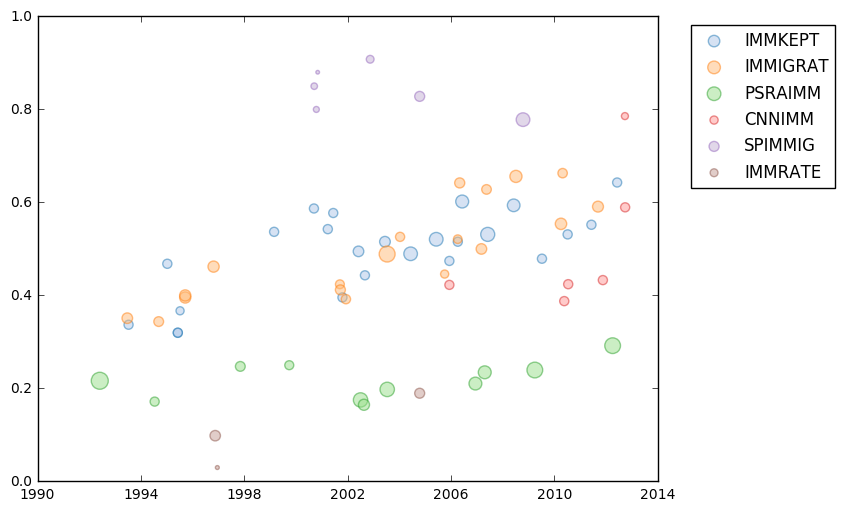

In [15]:
reload(plotting)

plotting.plot_polling_data(combined)
print ""

In [36]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
combined['salient'] = combined.apply(lambda row: int(row['stories'] >= 50), axis=1)

# add in interactions
# between tone and number of stories per quarter

#grouped['stories'] = np.log(grouped['stories'])


combined['toneXstories'] = combined['tone'] * combined['stories']
combined['directnessXstories'] = combined['directness'] * combined['stories']

combined['proXstories'] = combined['Pro'] * combined['stories']
combined['antiXstories'] = combined['Anti'] * combined['stories']
combined['neutralXstories'] = combined['Neutral'] * combined['stories']

combined['entropyXstories'] = combined['entropy'] * combined['stories']
combined['entropyXtone'] =  combined['entropy'] * combined['tone']
combined['entropyXtoneXstories'] =  combined['entropy'] * combined['tone'] * combined['stories']

combined['toneXdirectness'] = combined['tone'] * combined['directness']
combined['toneXdirectnessXstories'] = combined['tone'] * combined['directness'] * combined['stories']

combined['entropyXtoneXdirectness'] = combined['entropy'] * combined['tone'] * combined['directness']


combined['toneXsalient'] = combined['tone'] * combined['salient']
combined['directnessXsalient'] = combined['directness'] * combined['salient']

#for year in range(1990,2014):
#    combined['post_' + str(year)] = [int(combined.index[i][0] > year) for i in range(len(combined.index))]    
    
#combined['post_event_1990'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1991) for i in range(len(combined.index))]
#combined['post_event_1994'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1995) for i in range(len(combined.index))]
#combined['post_event_2000'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2000.5) for i in range(len(combined.index))]
#combined['post_event_2001'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2002) for i in range(len(combined.index))]
#combined['post_event_2006'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2006.5) for i in range(len(combined.index))]


In [17]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)



-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <toneXstories> + <IMMKEPT> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM>
             + <SPIMMIG> + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   7

R-squared:         0.8198
Adj R-squared:     0.8023

Rmse:              0.0494

F-stat (6, 62):    46.9982, p-value:     0.0000

Degrees of Freedom: model 6, resid 62

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
  toneXstories     0.0010     0.0002       4.51     0.0000     0.0006     0.0014
       IMMKEPT     0.3589     0.0303      11.85     0.0000     0.2995     0.4183
      IMMIGRAT     0.3410     0.0311      10.95     0.0000     0.2800     0.4021
       PSRAIMM     0.0794     0.0322       2.47     0.0164     0.0163     0.1

In [18]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <toneXstories> + <IMMKEPT> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         68
Number of Degrees of Freedom:   8

R-squared:         0.8397
Adj R-squared:     0.8210

Rmse:              0.0459

F-stat (7, 60):    44.8962, p-value:     0.0000

Degrees of Freedom: model 7, resid 60

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4070     0.0689       5.90     0.0000     0.2719     0.5421
  toneXstories     0.0009     0.0002       4.20     0.0001     0.0005     0.0013
       IMMKEPT     0.3602     0.0282      12.78     0.0000     0.3050     0.4154
      IMMIGRAT     0.3448     0.0290      11.90     0.00

In [19]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <IMMKEPT> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM>
             + <SPIMMIG> + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   8

R-squared:         0.8274
Adj R-squared:     0.8076

Rmse:              0.0487

F-stat (7, 61):    41.7673, p-value:     0.0000

Degrees of Freedom: model 7, resid 61

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2534     0.0597       4.25     0.0001     0.1365     0.3704
       stories     0.0002     0.0001       3.68     0.0005     0.0001     0.0003
       IMMKEPT     0.3496     0.0301      11.61     0.0000     0.2906     0.4087
      IMMIGRAT     0.3356     0.0309      10.87     0.0000     0.2751    

In [20]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <IMMKEPT> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         68
Number of Degrees of Freedom:   9

R-squared:         0.8486
Adj R-squared:     0.8281

Rmse:              0.0450

F-stat (8, 59):    41.3454, p-value:     0.0000

Degrees of Freedom: model 8, resid 59

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.3979     0.0688       5.78     0.0000     0.2631     0.5328
          tone     0.2886     0.0570       5.06     0.0000     0.1769     0.4004
       stories     0.0001     0.0000       2.63     0.0109     0.0000     0.0002
       IMMKEPT     0.3546     0.0278      12.75     

In [21]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <IMMKEPT> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   9

R-squared:         0.8274
Adj R-squared:     0.8044

Rmse:              0.0491

F-stat (8, 60):    35.9476, p-value:     0.0000

Degrees of Freedom: model 8, resid 60

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2560     0.1061       2.41     0.0189     0.0480     0.4640
       stories     0.0002     0.0001       1.81     0.0754    -0.0000     0.0004
  toneXstories    -0.0000     0.0005      -0.03     0.9756    -0.0011     0.0010
       IMMKEPT     0.3495     0.0305      11.47     0.00

In [22]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <IMMKEPT>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         68
Number of Degrees of Freedom:   10

R-squared:         0.8486
Adj R-squared:     0.8252

Rmse:              0.0453

F-stat (9, 58):    36.1326, p-value:     0.0000

Degrees of Freedom: model 9, resid 58

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.3969     0.0699       5.67     0.0000     0.2598     0.5339
          tone     0.2991     0.1058       2.83     0.0064     0.0918     0.5064
       stories     0.0001     0.0001       1.34     0.1842    -0.0001     0.0003
  toneXstories    -0.0001     0.00

In [23]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <entropy> + <IMMKEPT> + <IMMIGRAT> + <PSRAIMM>
             + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   9

R-squared:         0.8468
Adj R-squared:     0.8263

Rmse:              0.0463

F-stat (8, 60):    41.4489, p-value:     0.0000

Degrees of Freedom: model 8, resid 60

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.3036     0.0579       5.25     0.0000     0.1902     0.4170
       stories     0.0002     0.0000       3.59     0.0007     0.0001     0.0003
       entropy    -0.4586     0.1016      -4.51     0.0000    -0.6579    -0.2594
       IMMKEPT     0.3605     0.0286      12.59     0.0000   

In [24]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <entropy> + <IMMKEPT>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         68
Number of Degrees of Freedom:   10

R-squared:         0.8622
Adj R-squared:     0.8408

Rmse:              0.0433

F-stat (9, 58):    40.3066, p-value:     0.0000

Degrees of Freedom: model 9, resid 58

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.3496     0.0675       5.18     0.0000     0.2173     0.4820
          tone     0.3321     0.0561       5.92     0.0000     0.2221     0.4422
       stories     0.0001     0.0000       2.63     0.0109     0.0000     0.0002
       entropy    -0.3770     0.0969   

In [25]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <entropy> + <entropyXtone>
             + <IMMKEPT> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   11

R-squared:         0.8691
Adj R-squared:     0.8466

Rmse:              0.0435

F-stat (10, 58):    38.5235, p-value:     0.0000

Degrees of Freedom: model 10, resid 58

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    12.5012     2.1440       5.83     0.0000     8.2990    16.7035
       stories     0.0002     0.0001       2.46     0.0171     0.0000     0.0004
  toneXstories    -0.0004     0.0005      -0.88     0.3800    -0.0013     0.0005
       entr

In [26]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <entropy>
             + <entropyXtone> + <IMMKEPT> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM>
             + <SPIMMIG> + <intercept>

Number of Observations:         68
Number of Degrees of Freedom:   12

R-squared:         0.8905
Adj R-squared:     0.8690

Rmse:              0.0392

F-stat (11, 56):    41.4167, p-value:     0.0000

Degrees of Freedom: model 11, resid 56

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4085     0.0632       6.46     0.0000     0.2846     0.5323
          tone    14.0358     1.9936       7.04     0.0000    10.1282    17.9433
       stories     0.0001     0.0001       1.64     0.1075    -0.0000  

In [27]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <entropy> + <entropyXtone> + <IMMKEPT>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   10

R-squared:         0.8684
Adj R-squared:     0.8483

Rmse:              0.0433

F-stat (9, 59):    43.2430, p-value:     0.0000

Degrees of Freedom: model 9, resid 59

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    12.1884     2.1230       5.74     0.0000     8.0272    16.3496
       stories     0.0002     0.0000       3.49     0.0009     0.0001     0.0002
       entropy     0.3293     0.1714       1.92     0.0596    -0.0067     0.6652
  entropyXtone    -5.0178     0.8990      -

In [28]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <entropy> + <entropyXtone>
             + <IMMKEPT> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         68
Number of Degrees of Freedom:   11

R-squared:         0.8902
Adj R-squared:     0.8710

Rmse:              0.0389

F-stat (10, 57):    46.2345, p-value:     0.0000

Degrees of Freedom: model 10, resid 57

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4142     0.0621       6.67     0.0000     0.2924     0.5360
          tone    13.9879     1.9782       7.07     0.0000    10.1107    17.8650
       stories     0.0001     0.0000       2.36     0.0216     0.0000     0.0002
       

In [65]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <toneXstories> + <entropy> + <entropyXtone> + <IMMKEPT>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   9

R-squared:         0.8415
Adj R-squared:     0.8204

Rmse:              0.0471

F-stat (8, 60):    39.8307, p-value:     0.0000

Degrees of Freedom: model 8, resid 60

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
  toneXstories     0.0007     0.0002       2.85     0.0060     0.0002     0.0012
       entropy    -0.4631     0.1044      -4.43     0.0000    -0.6678    -0.2584
  entropyXtone     0.0750     0.0288       2.61     0.0116     0.0186     0.1313
       IMMKEPT     0.3707     0.0289      12.81 